# Small World Graphs

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns


# I set the random seed so the notebook 
# produces the same results every time.
np.random.seed(17)

In [3]:
# node colors for drawing networks
colors = sns.color_palette('pastel', 5)
#sns.palplot(colors)
sns.set_palette(colors)

## Regular ring lattice

To make a ring lattice, I'll start with a generator function that yields edges between each node and the next `halfk` neighbors.

In [4]:
# GWT: notice the use of halfk instead of k
# This ensures that k is even; it must be b/c of symmetry
def adjacent_edges(nodes, halfk):
    """Yields edges between each node and `halfk` neighbors.
    
    halfk: number of edges from each node
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

We can test it with 3 nodes and `halfk=1`

In [5]:
nodes = range(3)
for edge in adjacent_edges(nodes, 1):
    print(edge)

(0, 1)
(1, 2)
(2, 0)


Now we use `adjacent_edges` to write `make_ring_lattice`

In [6]:
# GWT: note // does floor division
def make_ring_lattice(n, k):
    """Makes a ring lattice with `n` nodes and degree `k`.
    
    Note: this only works correctly if k is even.
    
    n: number of nodes
    k: degree of each node
    """
    G = nx.Graph()
    nodes = range(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, k//2))
    return G

And we can test it out with `n=10` and `k=4`

In [7]:
lattice = make_ring_lattice(10, 4)

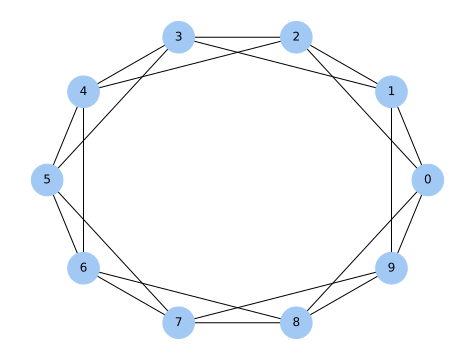

In [9]:
nx.draw_circular(lattice, 
                 node_color='C0', 
                 node_size=1000, 
                 with_labels=True)


**Exercise:** To see how this function fails when `k` is odd, run it again with `k=3` or `k=5`.

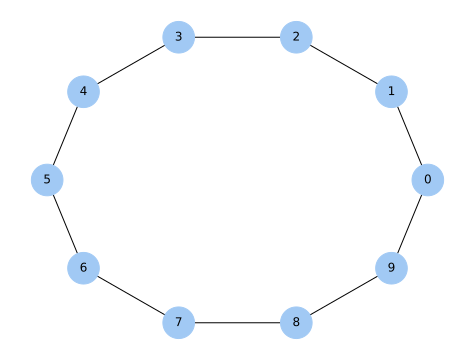

In [15]:
lattice = make_ring_lattice(10, 3)
nx.draw_circular(lattice, 
                 node_color='C0', 
                 node_size=1000, 
                 with_labels=True)

#latticeTwo = make_ring_lattice(10, 5)
#nx.draw_circular(latticeTwo, 
#                 node_color='C2', 
#                 node_size=1000, 
#                 with_labels=True)

## WS graph

To make a WS graph, you start with a ring lattice and then rewire.

In [47]:
def make_ws_graph(n, k, p):
    """Makes a Watts-Strogatz graph.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring an edge
    """
    ws = make_ring_lattice(n, k)
    rewire(ws, p)
    return ws

Here's the function that does the rewiring

In [48]:
# GWT: note that {} is short-hand for set construction
# Note the set operations used to remove node u and
# the set of nodes to which u is connected, in order
# to leave candidates for random connectivity

def rewire(G, p):
    """Rewires each edge with probability `p`.
    
    G: Graph
    p: float
    """
    nodes = set(G)
    for u, v in G.edges():
        if flip(p):
            choices = nodes - {u} - set(G[u])
            new_v = np.random.choice(list(choices))
            G.remove_edge(u, v)
            G.add_edge(u, new_v)
            
def flip(p):
    """Returns True with probability `p`."""
    return np.random.random() < p

Here's an example with `p=0.2`

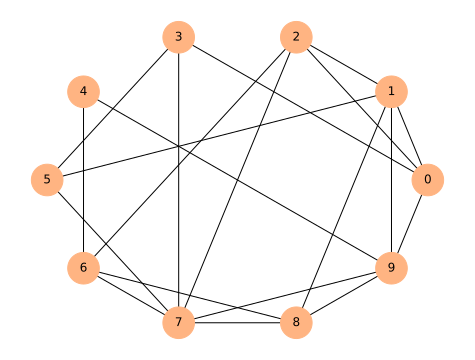

In [49]:
ws = make_ws_graph(10, 4, 0.2)
nx.draw_circular(ws, 
                 node_color='C1', 
                 node_size=1000, 
                 with_labels=True)

Just checking that we have the same number of edges we started with:

In [50]:
len(lattice.edges()), len(ws.edges())

(20, 20)

Now I'll generate a plot that shows WS graphs for a few values of `p`

In [ ]:
n = 10
k = 4
ns = 100

plt.subplot(1,3,1)
ws = make_ws_graph(n, k, 0)
nx.draw_circular(ws, node_size=ns)
plt.axis('equal')

plt.subplot(1,3,2)
ws = make_ws_graph(n, k, 0.2)
nx.draw_circular(ws, node_size=ns)
plt.axis('equal')

plt.subplot(1,3,3)
ws = make_ws_graph(n, k, 1.0)
nx.draw_circular(ws, node_size=ns)
plt.axis('equal')

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1)
savefig('chap03-2.pdf')

**Exercise:** What is the order of growth of `rewire`?

In [16]:
# Rewires each edge so runs edge number of times
# random list choices, edge addition or removal is constant
# assigning choices is complex and I think it is linear (n).
# therefore I think it is O(n*m)

## Clustering

The following function computes the local clustering coefficient for a given node, `u`:

In [17]:
# GWT: If a node has less than 2 neighbours,
# the clustering coefficient is undefined
def node_clustering(G, u):
    """Computes local clustering coefficient for `u`.
    
    G: Graph
    u: node
    
    returns: float
    """
    neighbors = G[u]
    k = len(neighbors)
    if k < 2:
        return np.nan
        
    possible = k * (k-1) / 2
    exist = 0    
    for v, w in all_pairs(neighbors):
        if G.has_edge(v, w):
            exist +=1
    return exist / possible

def all_pairs(nodes):
    """Generates all pairs of nodes."""
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v

The network average clustering coefficient is just the mean of the local CCs.

In [18]:
# GWT: np.nanmean computes the arithmetic mean across the specified
# axis, ignoring NaNs
def clustering_coefficient(G):
    """Average of the local clustering coefficients.
    
    G: Graph
    
    returns: float
    """
    cu = [node_clustering(G, node) for node in G]
    return np.nanmean(cu)

In a ring lattice with `k=4`, the clustering coefficient for each node should be 0.5

In [19]:
lattice = make_ring_lattice(10, 4)
node_clustering(lattice, 1)

0.5

And the network average should be 0.5

In [35]:
clustering_coefficient(lattice)
#timing previous one
%timeit clustering_coefficient(lattice)

248 µs ± 3.38 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Correct.

**Exercise:** Write a version of `node_clustering` that replaces the `for` loop with a list comprehension. Is it faster?

In [37]:
def node_clustering(G, u):
    neighbours = G[u]
    k = len(neighbours)
    
    if k < 2:
        return np.nan
    
    edgeNum = [G.has_edge(v, w) for v, w in all_pairs(neighbours)]
    
    return np.mean(edgeNum)

clustering_coefficient(lattice)
#comparing the times from the version before and the new one, the new one seems to take the same time
#There are usually deviations where the previous one is faster or slower but no strong correlation to suggest a difference

0.5

In [38]:
%timeit clustering_coefficient(lattice)

241 µs ± 6.37 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


**Exercise:** What is the order of growth of `clustering_coefficient` in terms of `n`, `m`, and `k`?

In [ ]:
#node_clustering has nested for loops through the function all_pairs when iterating through neighbours (k). Hence it can be considered a quadratic in k. 

#If we assume that the graph is a ring lattice where k is not proportional to n. The order of growth becomes O((k^2)*n)). 

#If the graph is complete then k will be equal to n-1 where we can assume k = n, therefore the order of growth becomes O(n^3).

## Path length

The following function computes path lengths between all pairs of different nodes:

In [39]:
def path_lengths(G):
    length_iter = nx.shortest_path_length(G)
    for source, dist_map in length_iter:
        for dest, dist in dist_map.items():
            if (source != dest):
                yield dist

The characteristic path length is the mean path length for all pairs.

In [40]:
def characteristic_path_length(G):
    return np.mean(list(path_lengths(G)))

On a complete graph, the average path length should be 1

In [41]:
complete = nx.complete_graph(10)
characteristic_path_length(complete)

1.0

On a ring lattice with `n=1000` and `k=10`, the mean is about 50

In [42]:
lattice = make_ring_lattice(1000, 10)
characteristic_path_length(lattice)

50.450450450450454

**Exercise:**  What is the mean path length in a ring lattice with `n=10` and `k=4`?

In [44]:
lattice = make_ring_lattice(10, 4)
characteristic_path_length(lattice)
#The mean path length is 1.67

1.6666666666666667

## The experiment

This function generates a WS graph with the given parameters and returns a pair of (mean path length, clustering coefficient):

In [51]:
def run_one_graph(n, k, p):
    """Makes a WS graph and computes its stats.
    
    n: number of nodes
    k: degree of each node
    p: probability of rewiring
    
    returns: tuple of (mean path length, clustering coefficient)
    """
    ws = make_ws_graph(n, k, p)    
    mpl = characteristic_path_length(ws)
    cc = clustering_coefficient(ws)
    print(mpl, cc)
    return mpl, cc

With `n=1000` and `k=10`, it takes about a second on my computer:

In [52]:
%time run_one_graph(1000, 10, 0.01)

8.331341341341341 0.643806349206349
Wall time: 1.7 s


(8.331341341341341, 0.643806349206349)

Now we'll run it with a range of values for `p`.

In [53]:
ps = np.logspace(-4, 0, 9)
print(ps)

[1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00]


This function runs each value of `p` 20 times and returns a dictionary that maps from each `p` to a list of (mpl, cc) pairs.

In [54]:
def run_experiment(ps, n=1000, k=10, iters=20):
    """Computes stats for WS graphs with a range of `p`.
    
    ps: sequence of `p` to try
    n: number of nodes
    k: degree of each node
    iters: number of times to run for each `p`
    
    returns: NumPy array where each row represents the mean (mpl, cc)
             for a given p
    """
    res = []
    for p in ps:
        print(p)
        t = [run_one_graph(n, k, p) for _ in range(iters)]
        means = np.array(t).mean(axis=0)
        print(means)
        res.append(means)
    return np.array(res)

Here are the raw results.  Warning: this takes a few minutes to run.

In [55]:
%time res = run_experiment(ps)

0.0001
40.86805205205205 0.6662065656565656
50.450450450450454 0.6666666666666665
50.450450450450454 0.6666666666666665
42.05552152152152 0.6662065656565656
50.450450450450454 0.6666666666666665
46.72214214214214 0.6664232323232322
50.450450450450454 0.6666666666666665
50.42111911911912 0.6663848484848484
39.851057057057055 0.6662787878787878
50.450450450450454 0.6666666666666665
50.450450450450454 0.6666666666666665
50.450450450450454 0.6666666666666665
50.450450450450454 0.6666666666666665
40.36740940940941 0.665890909090909
38.149765765765764 0.6656742424242422
49.73425425425425 0.6662787878787878
50.450450450450454 0.6666666666666665
39.614108108108105 0.6664232323232322
50.450450450450454 0.6666666666666665
50.450450450450454 0.6666666666666665
[47.13691922  0.66645503]
0.00031622776601683794
38.540914914914914 0.6663510101010099
32.336248248248246 0.6657196969696969
37.61156956956957 0.6656742424242423
26.550176176176176 0.6655070707070706
36.602762762762765 0.665890909090909
34.

In [56]:
res

array([[4.71369192e+01, 6.66455025e-01],
       [3.84809534e+01, 6.66001515e-01],
       [2.76119482e+01, 6.64731793e-01],
       [1.60694682e+01, 6.60953106e-01],
       [8.84365796e+00, 6.47337551e-01],
       [5.98330440e+00, 6.07688437e-01],
       [4.43355626e+00, 4.90950285e-01],
       [3.57776366e+00, 2.19084487e-01],
       [3.26797227e+00, 9.29828673e-03]])

Let's get the results into a form that's easy to plot.

In [57]:
L, C = np.transpose(res)

In [58]:
L

array([47.13691922, 38.48095335, 27.61194825, 16.06946817,  8.84365796,
        5.9833044 ,  4.43355626,  3.57776366,  3.26797227])

In [59]:
C

array([0.66645503, 0.66600152, 0.66473179, 0.66095311, 0.64733755,
       0.60768844, 0.49095028, 0.21908449, 0.00929829])

And normalize them so they both start at 1.0

In [60]:
# GWT: Note that both series are monotonically decreasing
# So the first element is the maximum
L /= L[0]
C /= C[0]

Here's the plot that replicates Watts and Strogatz's Figure 2.

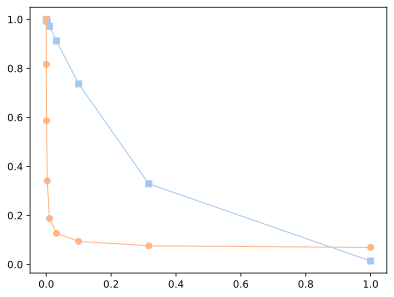

In [63]:
plt.plot(ps, C, 's-', linewidth=1, label='C(p) / C(0)')
plt.plot(ps, L, 'o-', linewidth=1, label='L(p) / L(0)')
#decorate(xlabel='Rewiring probability (p)', xscale='log',
#         title='Normalized clustering coefficient and path length',
#         xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])
#savefig('chap03-3.pdf')

## Breadth-first search

Now let's see how the shortest path algorithm works.  We'll start with BFS, which is the basis for Dijkstra's algorithm.

Here's our old friend, the ring lattice:

In [64]:
lattice = make_ring_lattice(10, 4)

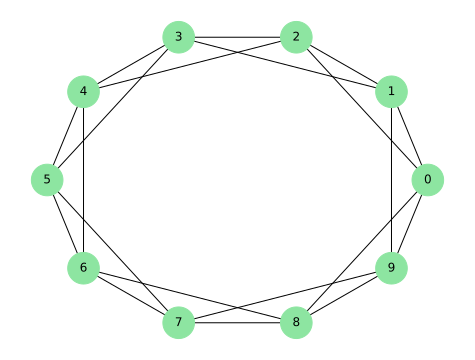

In [65]:
nx.draw_circular(lattice, 
                 node_color='C2', 
                 node_size=1000, 
                 with_labels=True)

And here's my implementation of BFS using a deque.

In [66]:
from collections import deque

def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            queue.extend(G.neighbors(node))
    return seen

It works:

In [67]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

Here's a version that's a little faster, but maybe less readable.

In [68]:
def reachable_nodes_bfs(G, start):
    """Finds reachable nodes by BFS.
    
    G: graph
    start: node to start at
    
    returns: set of reachable nodes
    """
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            neighbors = set(G[node]) - seen
            queue.extend(neighbors)
    return seen

It works, too.

In [69]:
reachable_nodes_bfs(lattice, 0)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Dijkstra's algorithm

Now we're ready for Dijkstra's algorithm, at least for graphs where all the edges have the same weight/length.

In [70]:
def shortest_path_dijkstra(G, source):
    """Finds shortest paths from `source` to all other nodes.
    
    G: graph
    source: node to start at
    
    returns: make from node to path length
    """
    dist = {source: 0}
    queue = deque([source])
    while queue:
        node = queue.popleft()
        new_dist = dist[node] + 1

        neighbors = set(G[node]).difference(dist)
        for n in neighbors:
            dist[n] = new_dist
        
        queue.extend(neighbors)
    return dist

Again, we'll test it on a ring lattice.

In [71]:
lattice = make_ring_lattice(10, 4)

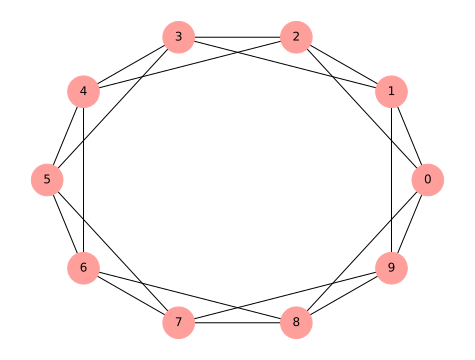

In [72]:
nx.draw_circular(lattice, 
                 node_color='C3', 
                 node_size=1000, 
                 with_labels=True)

Here's my implementation:

In [73]:
d1 = shortest_path_dijkstra(lattice, 0)
d1

{0: 0, 8: 1, 1: 1, 2: 1, 9: 1, 6: 2, 7: 2, 3: 2, 4: 2, 5: 3}

And here's the result from NetworkX:

In [74]:
d2 = nx.shortest_path_length(lattice, 0)
d2

{0: 0, 8: 1, 1: 1, 2: 1, 9: 1, 3: 2, 4: 2, 6: 2, 7: 2, 5: 3}

They are the same:

In [75]:
d1 == d2

True

**Exercise:** In a ring lattice with `n=1000` and `k=10`, which node is farthest from 0 and how far is it?  Use `shortest_path_dijkstra` to check your answer.

Note: the maximum distance between two nodes is the **diameter** of the graph.

In [78]:
lattice = make_ring_lattice(1000, 10)
d = shortest_path_dijkstra(lattice, 0)
#d
#The node furthest from zero is (501, 100)

## Exercises

**Exercise:** In a ring lattice, every node has the same number of neighbors.  The number of neighbors is called the **degree** of the node, and a graph where all nodes have the same degree is called a **regular graph**.

All ring lattices are regular, but not all regular graphs are ring lattices.  In particular, if `k` is odd, we can't construct a ring lattice, but we might be able to construct a regular graph.

Write a function called `make_regular_graph` that takes `n` and `k` and returns a regular graph that contains `n` nodes, where every node has `k` neighbors.  If it's not possible to make a regular graph with the given values of `n` and `k`, the function should raise a `ValueError`.

In [80]:
# we have adjacent edges but we need opposite edges to make the graph
#following code is the same as adjacent edges except for the loop
def opposite_edges(nodes):
    n = len(nodes)
    for i, u in enumerate(nodes):
        j = i + n//2
        v = nodes[j % n]
        yield u, v

In [84]:
#make graph n nodes with k neighbours
def make_regular_graph(n, k):

    #find number of edges via divmod based on k and store the tuple return in a,b
    #where edges are split into adj and opp
    adj, opp = divmod(k, 2)
    
    #gen graph
    G = nx.Graph()
    nodes = range(n)
    
    G.add_nodes_from(nodes)
    G.add_edges_from(adjacent_edges(nodes, adj))
    
    #is reg possible
    if opp:
        if n%2:
            #check if odd nodes (if nodes odd then it is not possible)
            raise ValueError(msg)
        G.add_edges_from(opposite_edges(nodes))
    return G

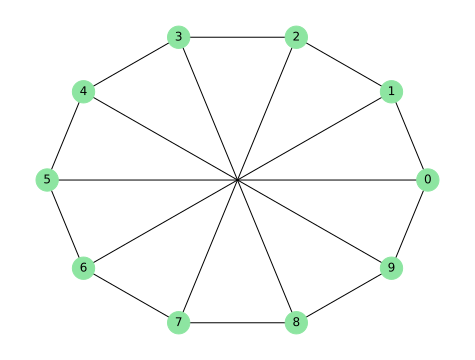

In [85]:
reg = make_regular_graph(10, 3)

nx.draw_circular(reg, 
                 node_color='C2', 
                 node_size=500, 
                 with_labels=True)

**Exercise:** My implementation of `reachable_nodes_bfs` is efficient in the sense that it is in $O(n + m)$, but it incurs a lot of overhead adding nodes to the queue and removing them.  NetworkX provides a simple, fast implementation of BFS, available from [the NetworkX repository on GitHub](https://github.com/networkx/networkx/blob/master/networkx/algorithms/components/connected.py).

Here is a version I modified to return a set of nodes:

In [88]:
def plain_bfs(G, source):
    """A fast BFS node generator"""
    seen = set()
    nextlevel = {source}
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in seen:
                seen.add(v)
                nextlevel.update(G[v])
    return seen

Compare this function to `reachable_nodes_bfs` and see which is faster.  Then see if you can modify this function to implement a faster version of `shortest_path_dijkstra`

In [89]:
lattice = make_ring_lattice(500, 10)
%timeit len(reachable_nodes_bfs(lattice, 0))

1.03 ms ± 45 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [90]:
%timeit len(plain_bfs(lattice, 0))
#plain bfs is faster

625 µs ± 33.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
#incomplete (ran out of time for this lab)
def shortest_path_dijkstra_new(G, source):
    seen = set()
    nextlevel = {source}
    while nextlevel:
        thislevel = nextlevel
        nextlevel = set()
        for v in thislevel:
            if v not in seen:
                seen.add(v)
                nextlevel.update(G[v])
    return seen

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

**Exercise:** The following implementation of a BFS contains two performance errors.  What are
they?  What is the actual order of growth for this algorithm?

In [ ]:
def bfs(G, start):
    """Breadth-first search on a graph, starting at top_node."""
    visited = set()
    queue = [start]
    while len(queue):
        curr_node = queue.pop(0)    # Dequeue
        visited.add(curr_node)

        # Enqueue non-visited and non-enqueued children
        queue.extend(c for c in G[curr_node]
                     if c not in visited and c not in queue)
    return visited

In [ ]:
#the first error is popping from the list while looping through it, as such the elements are shifting while the loop is running and results in a linear order
#the second error regards checking the nodes in list which has the same error of iterating through a list and results in an order of growth of linear
#if the graph is completely connected, the algorithm runs O(n) for looping the queue, O(n) for checking nodes and then O(n) for the last loop, overall O(n^3).

**Exercise:** In the book, I claimed that Dijkstra's algorithm does not work unless it uses BFS.  Write a version of `shortest_path_dijkstra` that uses DFS and test it on a few examples to see what goes wrong.

In [ ]:
#incomplete (ran out of time for this lab)